# European Calls

## Setup

### Imports

In [1]:
%run ../nn_option_pricer/_key_imports.py
import sys
sys.path.append("../")
from nn_option_pricer.bs import bs_eval_wrapper, bs_model_inference
from nn_option_pricer.nn_archi import *
from nn_option_pricer.utils import diagnosis_hedge, visualise_surface
%run ../nn_option_pricer/default_config.py

### Dataset

In [2]:
# read in dataset
feat_names = ["log(S/K)", "ttm"]
f_to_i = lambda x: feat_names.index(x)
N_FEATS = len(feat_names)

# train set
X_df = pd.read_csv("datasets/bs_train.csv")
Xs_train, ys_train = X_df[feat_names].values, X_df["call_true"].values
true_grads_train = X_df["true_d_log(S/K)"]

# test set
X_df_test = pd.read_csv("datasets/bs_test.csv")
Xs_test, ys_test = X_df_test[feat_names].values, X_df_test["call_true"].values
true_grads_test = X_df_test["true_d_log(S/K)"]

print("BASELINE MSE: ", np.mean((ys_test - ys_test.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys_test - ys_test.mean())))
print(X_df.shape)

moneyness = np.exp(Xs_test[:, f_to_i("log(S/K)")])
ttm = Xs_test[:, f_to_i("ttm")]
true = X_df_test["call_true"]
intrinsic_val = np.maximum(moneyness - 1.0, 0.0)
upper_bound = np.maximum(moneyness, 0.0)

all_res = []
all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

BASELINE MSE:  0.1654462172088685
BASELINE MAE:  0.33515645420746415
(65536, 12)


### Hyperparameter Config

In [14]:
print(nn_params)
print(fit_params)
nn_params['n_feats'] = N_FEATS

{'hidden_units': 64, 'n_layers': 2, 'dropout_ratio': 0.0, 'hidden_act': 'swish', 'output_act': None, 'batch_norm': True, 'kernel_init': 'lecun_normal', 'seed': 42, 'n_feats': 2}
{'epochs': 30, 'batch_size': 32, 'verbose': 0, 'validation_split': 0.2, 'shuffle': False, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x1370320d0>, <tensorflow_addons.callbacks.tqdm_progress_bar.TQDMProgressBar object at 0x1370321f0>]}


# Neural Networks

We consider
+ Feed-Forward Neural Network
+ ResNet
+ Gated
+ Neural PDE
+ Differential

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2)]               0         
                                                                 
 batch_normalization_27 (Bat  (None, 2)                8         
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 64)                192       
                                                                 
 batch_normalization_28 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_29 (Bat  (None, 64)               256

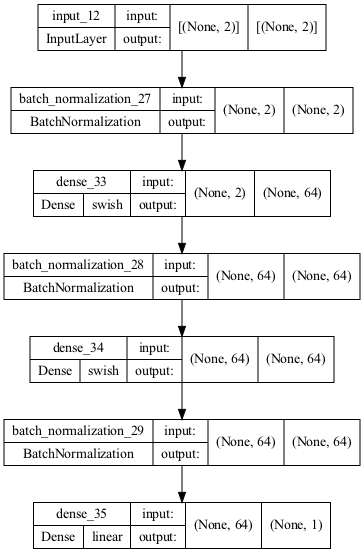

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 2)]               0         
                                                                 
 batch_normalization_30 (Bat  (None, 2)                8         
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 64)                192       
                                                                 
 batch_normalization_31 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_32 (Bat  (None, 64)               256

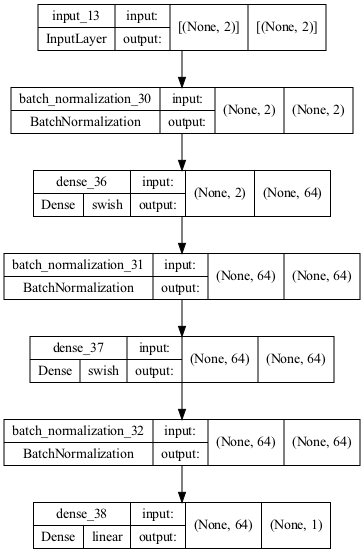

Model: "differential_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 2)]               0         
                                                                 
 batch_normalization_33 (Bat  (None, 2)                8         
 chNormalization)                                                
                                                                 
 dense_39 (Dense)            (None, 64)                192       
                                                                 
 batch_normalization_34 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_35 (Bat  (None, 64)      

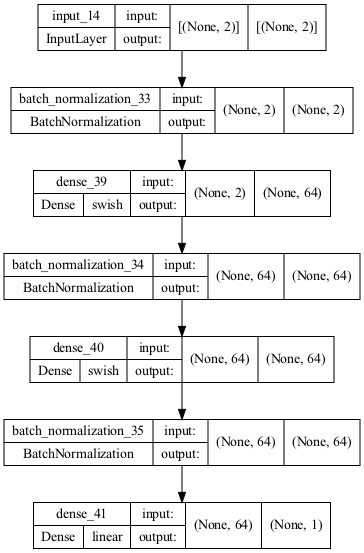

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

INFO:tensorflow:Assets written to: trained_models/bs/differential/assets
Model: "pde_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2)]               0         
                                                                 
 batch_normalization_36 (Bat  (None, 2)                8         
 chNormalization)                                                
                                                                 
 dense_42 (Dense)            (None, 64)                192       
                                                                 
 batch_normalization_37 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_43 (Dense)            (None, 64)                4160      
                                                  

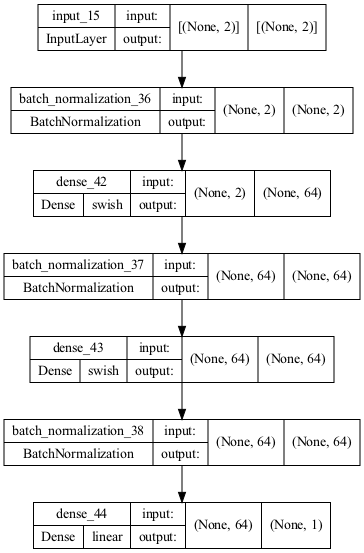

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

INFO:tensorflow:Assets written to: trained_models/bs/npde/assets
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 batch_normalization_39 (BatchN  (None, 2)           8           ['input_16[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 ttm (Dense)                    (None, 1)            3           ['batch_normalization_39[0][0]'] 
                                                                                                  
 moneyness (Dense)        

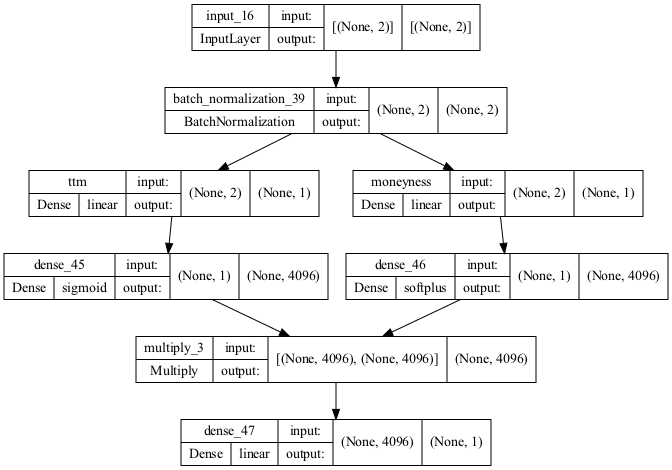

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

INFO:tensorflow:Assets written to: trained_models/bs/gated/assets


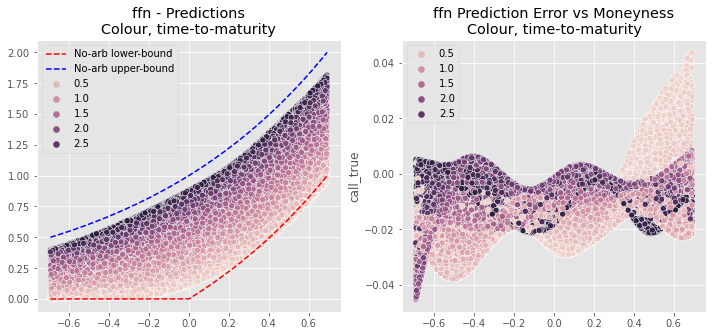

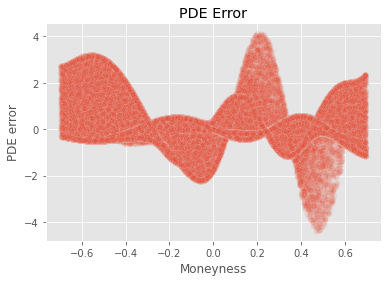

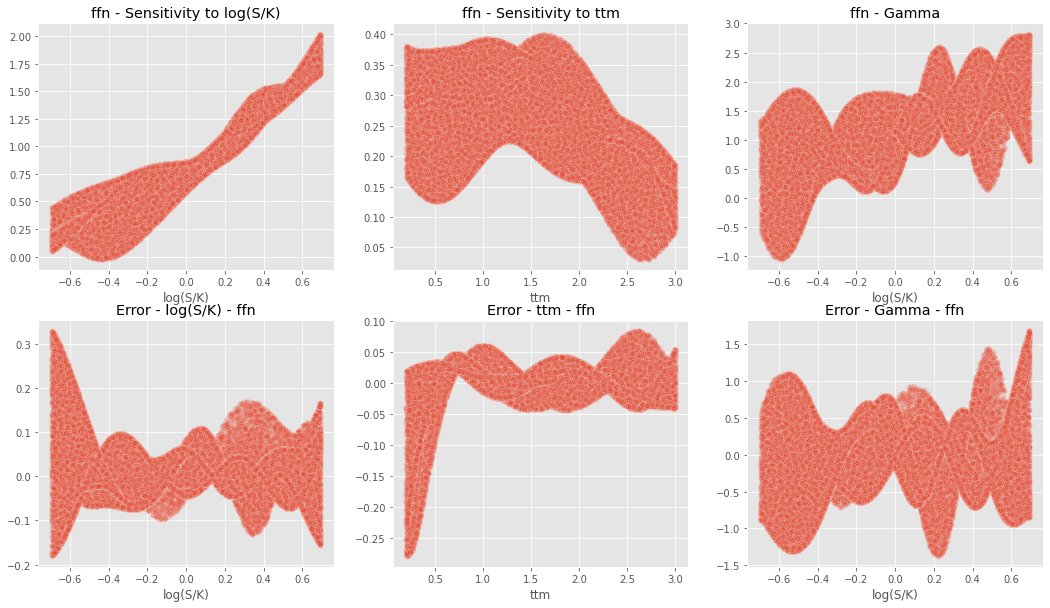

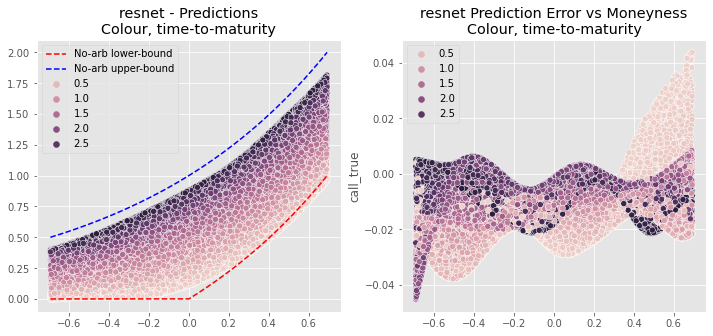

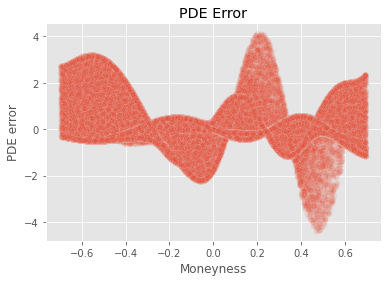

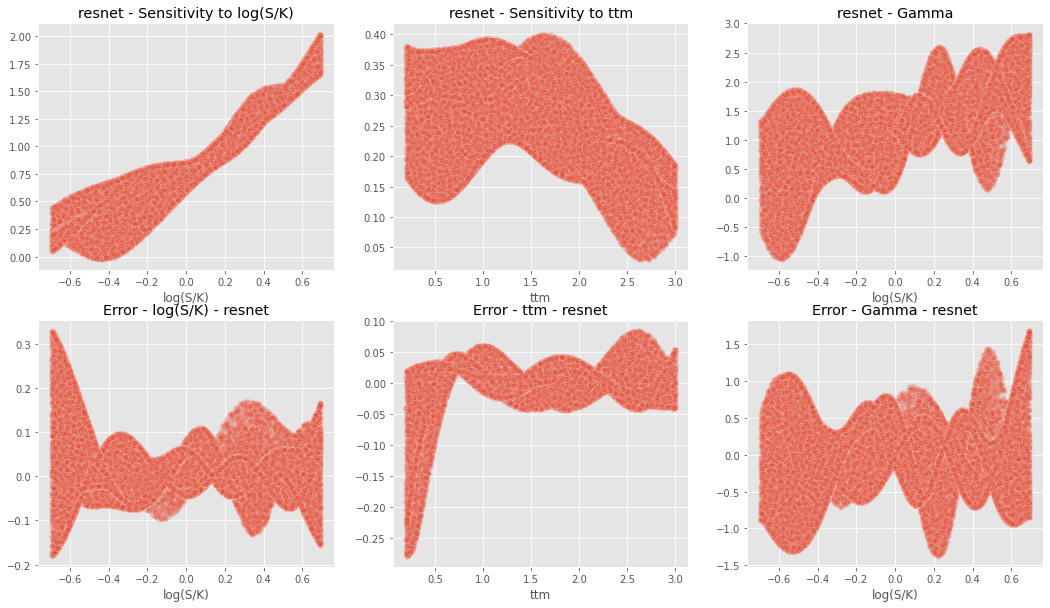

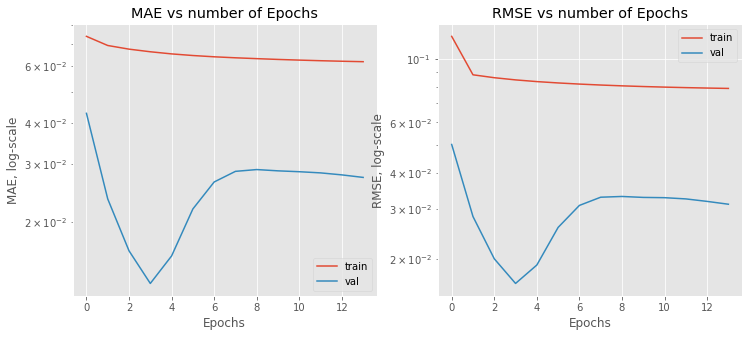

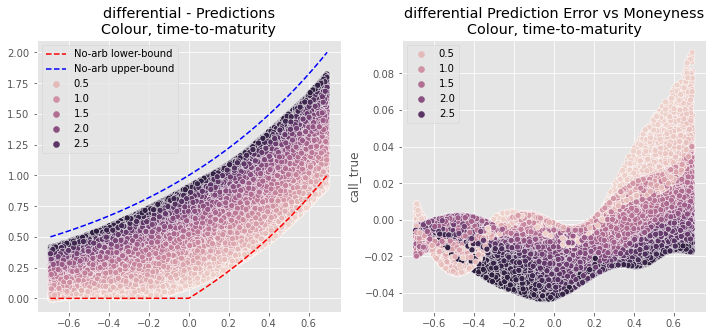

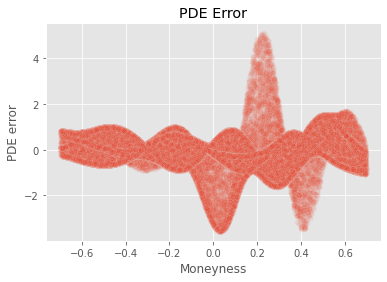

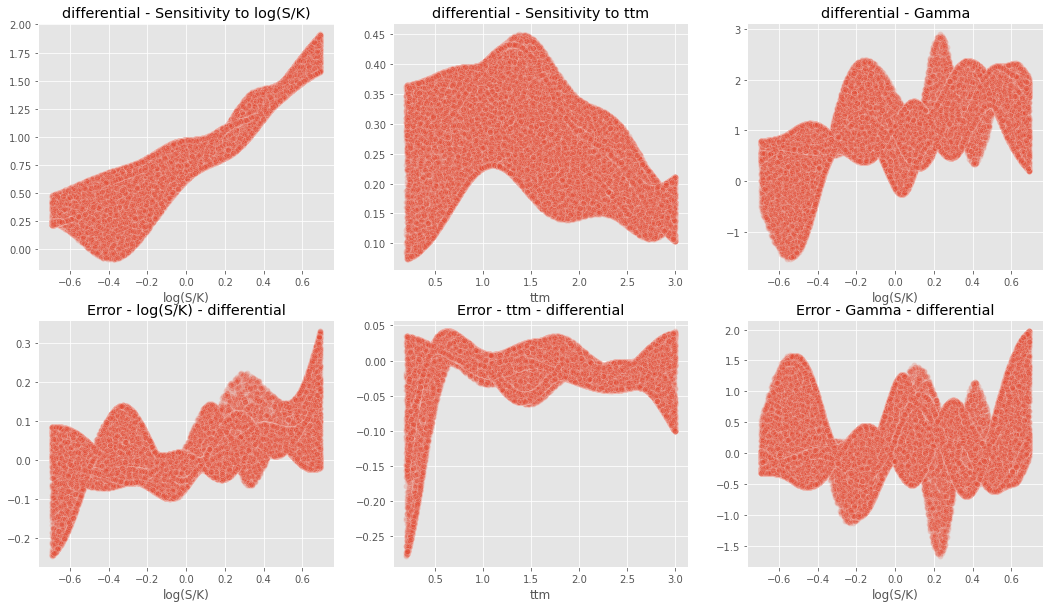

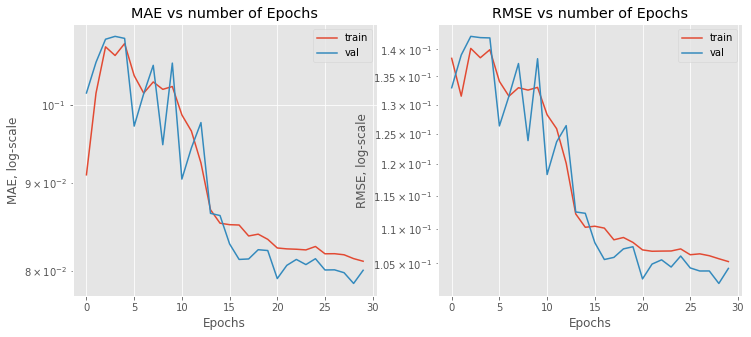

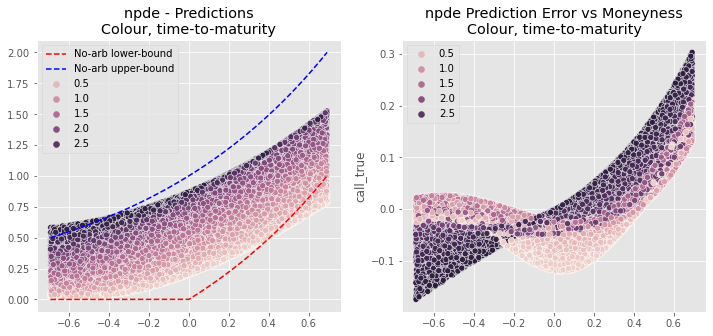

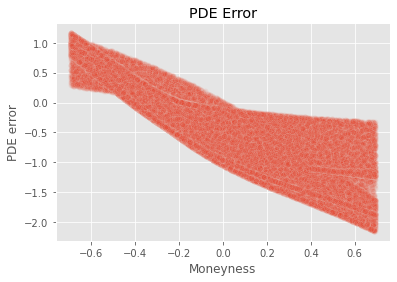

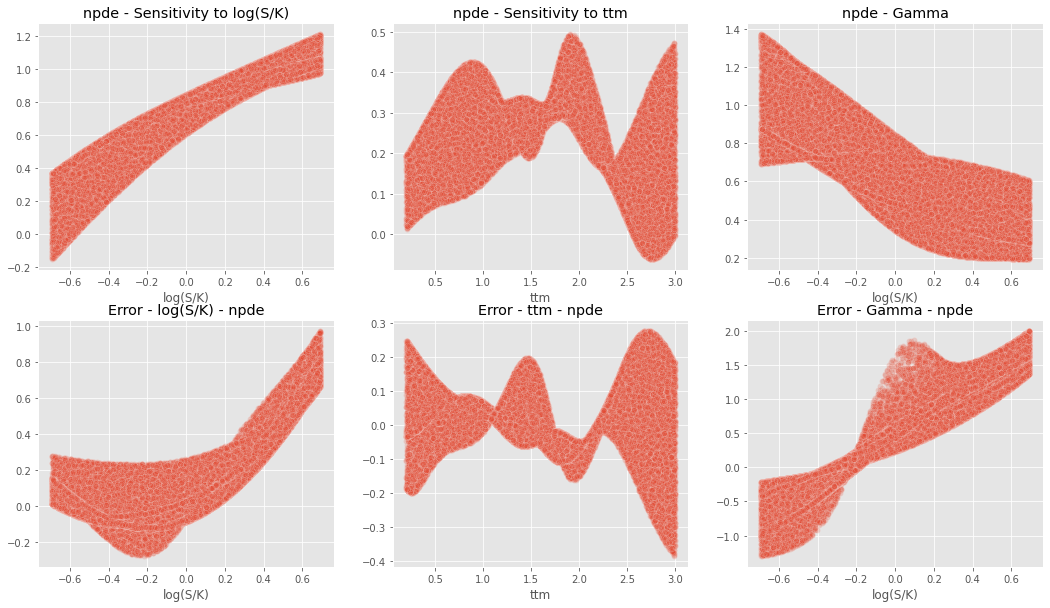

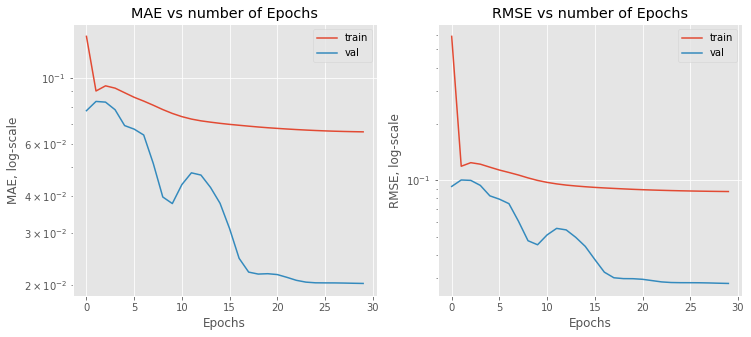

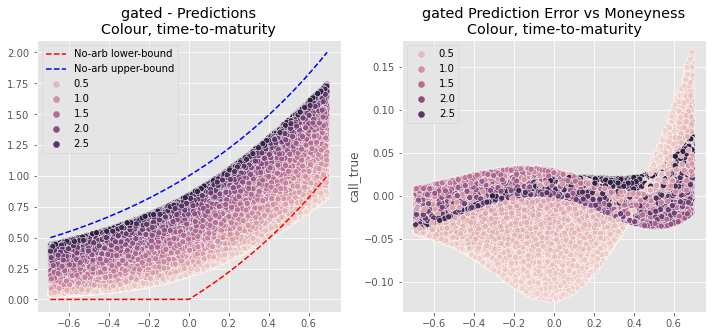

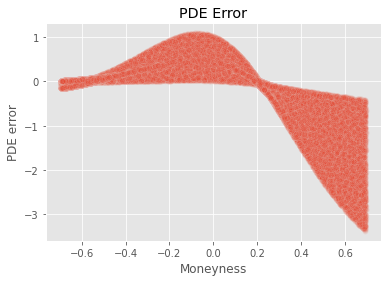

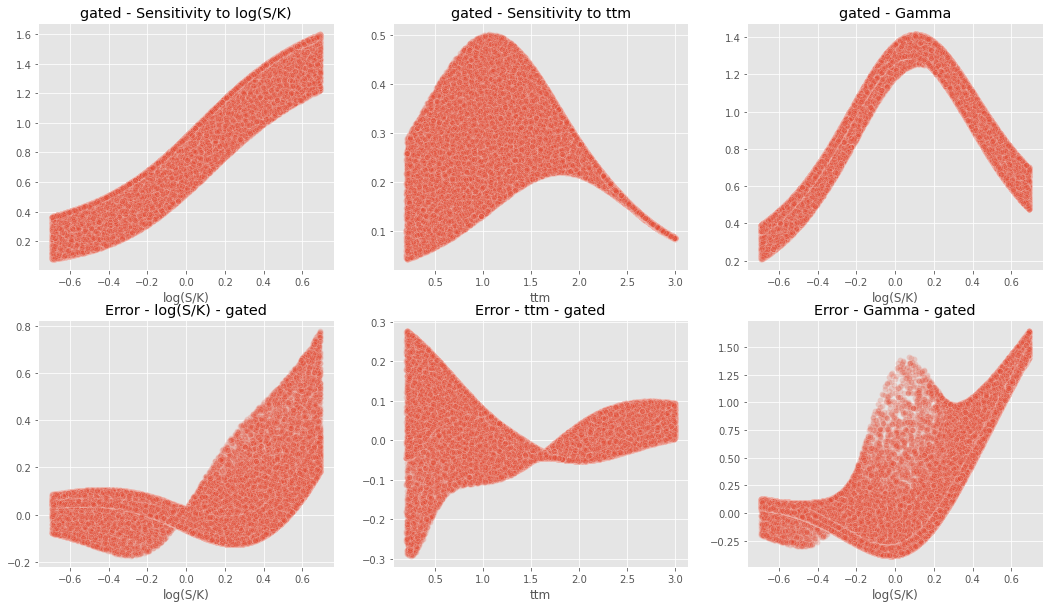

In [17]:
### define the neural network architecture
for METHOD in ["ffn", "resnet","differential", "npde","gated"]:
    metrics_to_add = []
    if METHOD == "differential":
        diff_model = make_model(**nn_params)
        all_models[METHOD] = DifferentialModel(diff_model.input, diff_model.output)
        all_models[METHOD].set_params()
        metrics_to_add  = ['loss','grad_loss']
    elif METHOD == "npde":
        pde_model = make_model(**nn_params)
        all_models[METHOD] = PDEModel(pde_model.input, pde_model.output)
        all_models[METHOD].set_params(lam = 10 ** 7)
        metrics_to_add  = ['loss','pde_loss']
    elif METHOD == "gated":
        nn_params2 = nn_params.copy()
        nn_params2['hidden_units'] = (nn_params2['hidden_units'] ** 2) / 4
        for param in ['n_layers', 'hidden_act', 'output_act', 'dropout_ratio']:
            nn_params2.pop(param)
        all_models[METHOD] = homogeneity_network(**nn_params2)
        gated_network_instantiate(all_models[METHOD], f_to_i)
    elif METHOD == "resnet":
        nn_params2 = nn_params.copy()
        nn_params2['resnet'] = True
        all_models[METHOD] = make_model(**nn_params2)
    else:
        all_models[METHOD] = make_model(**nn_params)
        
    opt = Adam(learning_rate=ExponentialDecay(LR, decay_steps=500,
        decay_rate=0.95,
    ))
    ### re-instantiate the optimizer, and compile the neural network
    all_models[METHOD].compile(optimizer=opt, **compile_params)
    ### summarize model
    all_models[METHOD].summary()
    display(tf.keras.utils.plot_model(
        all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
    ))
    #### Training
    try:
        #### try loading the model from disk
        all_models[METHOD] = tf.keras.models.load_model(f"trained_models/bs/{METHOD}")
        temp = bs_model_inference(all_models, all_model_preds, METHOD, all_model_grads, all_model_hessian, X_df_test, Xs_test, true, f_to_i, intrinsic_val, upper_bound)
    except:
        ### if not found, retrain
        if METHOD == "differential":
            train_time, history = train_nn(all_models[METHOD], Xs_train, (ys_train, true_grads_train), fit_params, metric_names + metrics_to_add)
        else:
            train_time, history = train_nn(all_models[METHOD], Xs_train, ys_train, fit_params, metric_names + metrics_to_add)
        all_models[METHOD].save(f"trained_models/bs/{METHOD}", save_format='tf')
        #### Inference
        temp = bs_model_inference(all_models, all_model_preds, METHOD, all_model_grads, all_model_hessian, X_df_test, Xs_test, true, f_to_i, intrinsic_val, upper_bound)
        temp["train_time"] = train_time
    all_res += [temp.copy()]

## Ensemble

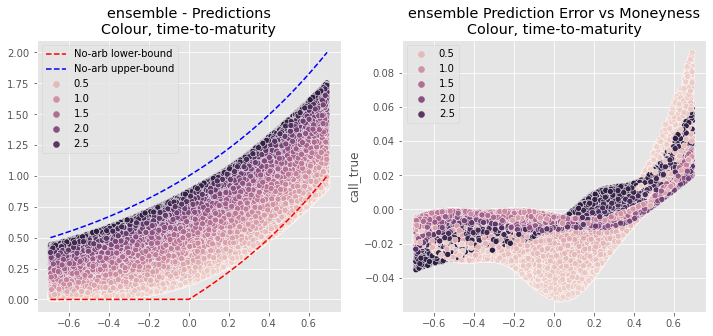

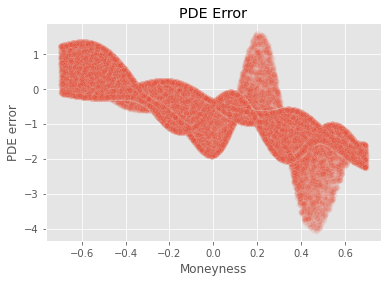

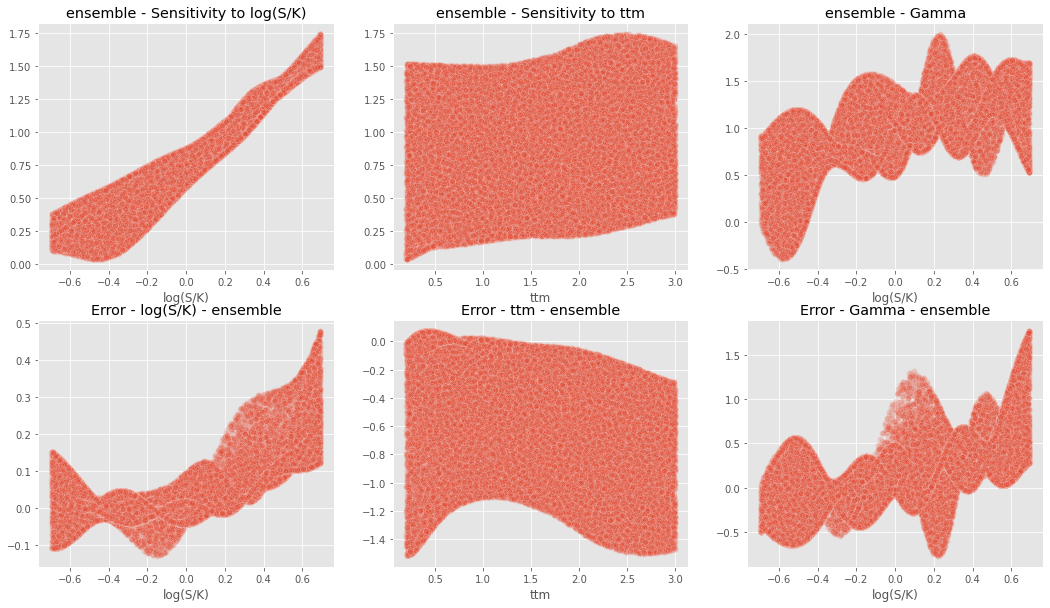

In [22]:
ensemble_preds = pd.DataFrame(all_model_preds).mean(axis=1).values
ensemble_hessian = pd.DataFrame({x:all_model_hessian[x][:,0] for x in all_model_hessian}).mean(axis = 1).values.reshape((-1, 1))
ensemble_grads = np.zeros((X_df_test.shape[0], N_FEATS))
for i in range(N_FEATS):
    ensemble_grads[:, i] =pd.DataFrame({x:all_model_grads[x][:,0] for x in all_model_grads}).mean(axis = 1).values
METHOD = "nn_ensemble"
temp = bs_eval_wrapper(
    X_df_test,
    true_val=true,
    preds=ensemble_preds,
    grads=ensemble_grads,
    hessian_moneyness=ensemble_hessian,
    lower_bound=intrinsic_val,
    upper_bound=upper_bound,
    METHOD=METHOD,
)

all_res += [temp.copy()]

## Polynomial

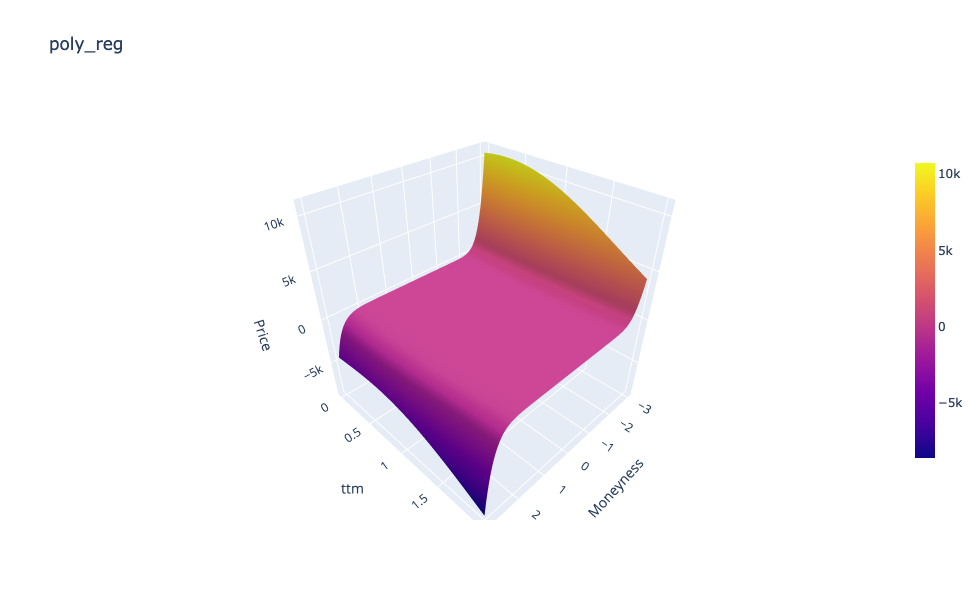

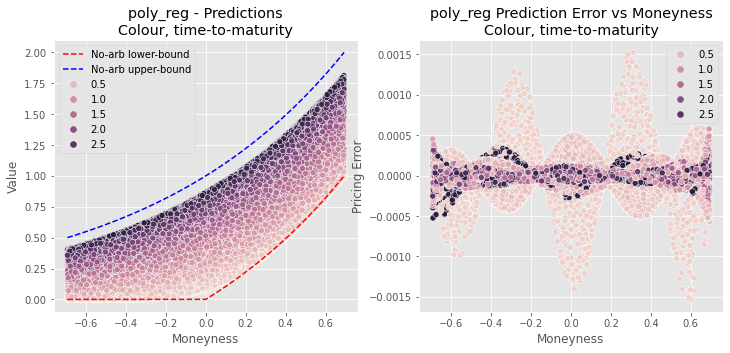

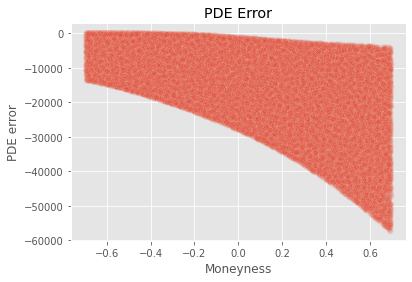

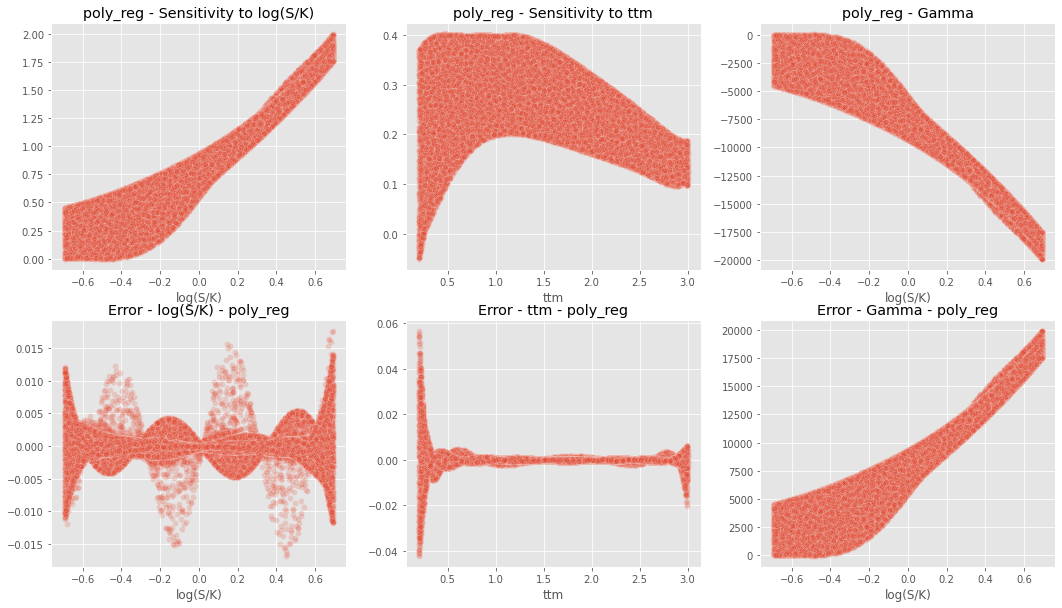

In [10]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline

METHOD = "poly_reg"
start = time.time()
degree = round(np.sqrt((2 * (nn_params["hidden_units"]))))
# spline = SplineTransformer(n_knots=5, degree=10, knots="uniform", extrapolation="linear")
train_time, inference_time = train_infer_poly(degree, Xs_train, ys_train, Xs_test, ys_test, feat_names, all_models, all_model_preds, all_model_grads, all_model_hessian, f_to_i, moneyness_var="log(S/K)", METHOD="poly_reg", eps=1e-4)
"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS)
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS**2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log(S/K)"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])
visualise_surface(
    SK, ts, all_models[METHOD].predict(X), title=METHOD
).show()
"""
Evaluate Predictions, Sensitivities
"""
temp = bs_eval_wrapper(
    X_df_test,
    true,
    all_model_preds[METHOD],
    all_model_grads[METHOD],
    all_model_hessian[METHOD],
    feat_names,
    lower_bound=intrinsic_val,
    upper_bound=upper_bound,
    METHOD=METHOD,
)
temp["model_parameters"] = len(all_models[METHOD]['lr'].coef_)
temp["train_time"] = train_time
temp["inference_time"] = inference_time
all_res += [temp.copy()]

In [11]:
all_res_df = (
    pd.concat(all_res)
    .reset_index()
    .drop_duplicates(subset=["index"], keep="last")
    .set_index("index")
    .T
)
print(all_res_df.to_latex())
display(all_res_df.style.background_gradient(axis=1))

\begin{tabular}{lr}
\toprule
index &      poly\_reg \\
\midrule
pred\_l1                    &      0.000084 \\
pred\_l2                    &      0.000132 \\
pred\_l\_inf                 &      0.001533 \\
pred\_lower\_bound\_violation &      0.000290 \\
pred\_upper\_bound\_violation &      0.000000 \\
PDE\_mean                   &  14603.594069 \\
PDE\_l1                     &  14603.595188 \\
PDE\_l2                     &  18469.570669 \\
PDE\_l\_inf                  &  57281.915331 \\
monotonicity\_error         &      0.000183 \\
time\_value\_error           &      0.003647 \\
convex\_error               &      0.999817 \\
model\_parameters           &     78.000000 \\
train\_time                 &      0.506751 \\
inference\_time             &      0.333169 \\
\bottomrule
\end{tabular}



# Calibration

In [ ]:
y_tensor = tf.Variable(ys_test.reshape((-1, 1)).astype(np.float32))
init_tensor = Xs_test.copy()
init_tensor[:, 1] = 1.0
init_tensor = tf.Variable(init_tensor)
vec = np.zeros((1, 2))
vec[:, 1] = 1.0
start = time.time()
calibration_error = []

# opt = tf.keras.optimizers.Adam(learning_rate=0.1)

with tf.GradientTape() as y_tape:
    y_tape.watch(y_tensor)
    for i in tqdm(range(50)):
        with tf.GradientTape() as tape:
            tape.watch(init_tensor)
            error  = (y_tensor - all_models["ffn"](init_tensor)) ** 2
            grad = tape.gradient(error, init_tensor)
        init_tensor = init_tensor - grad * vec
    y_grad = y_tape.batch_jacobian(init_tensor, y_tensor)
cal_time = time.time() - start

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
errors = error.numpy()

In [ ]:
fig, ax = plt.subplots()
sns.histplot(errors, bins = 50, ax = ax)
ax.set_xscale("log")

In [ ]:
cal_error = (Xs_test - init_tensor)[:,1].numpy()
sns.histplot(cal_error)

In [ ]:
sns.scatterplot(Xs_test[:,0], y_grad[:, 1, :].numpy().reshape(-1), hue = ys_test)

In [ ]:
sns.scatterplot(ys_test, y_grad[:, 1, :].numpy().reshape(-1), hue = Xs_test[:,1])

# Hedge Analysis

In [ ]:
# preds = model.predict(Xs).reshape(-1)
# X_tensor = tf.Variable(Xs)
# with tf.GradientTape() as tape:
#     output = model(X_tensor)
#     grads = tape.gradient(output, X_tensor)

# delta = grads[:,0].numpy().reshape((-1, 32))
# St = X_df['log(S/K)'].values.reshape((2048, -1))
# payoff = X_df.groupby('path')['call_payoff'].mean().values
# hedge_pnl = preds[::32] + np.sum(delta[:, :-1] * np.diff(St, axis = 1), axis = 1) - payoff

# sns.histplot(hedge_pnl)